In [2]:
from pathlib import Path
from ezfit import FitPDF, Contribution

path_CeO2 = Path('/home/ben/DESY_PDF/0_data/config/mask_MP/CeO2_Standard_abs0_10s_00026.gr')


CeO2 = Contribution(cif_name='CeO2', cf_name='bulkCF', formula='CeO2')

fit = FitPDF(path_CeO2, contributions=[CeO2])

fit.update_recipe()
fit.apply_restraints()
fit.run_fit()

No meta data found for CeO2
attempting to fit instrumental parameters
Some quantities invalid due to missing profile uncertainty_Biso, CeO2_Ce_Biso, CeO2_O_occ, CeO2_Ce_occ, qdamp, qbroad
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       781.02233679
Contributions  781.02233679
Restraints     0.00000000
Chi2           781.02233679
Reduced Chi2   0.03927498
Rw             0.21818702

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
CeO2_Ce_Biso  2.60116400e-01 +/- 9.03920162e-03
CeO2_Ce_occ   9.87756037e-01 +/- 2.62421996e+05
CeO2_O_Biso   3.35154508e-01 +/- 7.00371739e-02
CeO2_O_occ    4.98552471e-01 +/- 1.32452879e+05
CeO2_a        5.41516333e+00 +/- 1.18209610e-04
CeO2_delta2   4.99758435e+00 +/- 1.01358693e+00
CeO2_scale    2.56756092e-01 +/- 6.82136491e+04
qbroad        6.02672601e-03 +/- 1.64367546e-03
qdamp         2.25646932e-02 +/- 

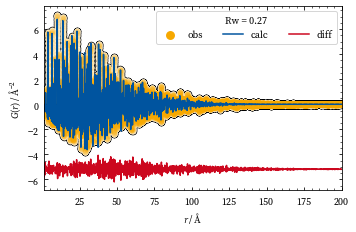

In [4]:
import matplotlib.pyplot as plt


fig, ax = plot_PDF(fit.recipe)
# set background color white

fig.set_facecolor('white')

plt.savefig('q_broad_damp.png', dpi=600)

In [3]:
from ezplot import create_basic_plot, scatter_w_outline
import numpy as np
import re 


def plot_PDF(recipe):
    r, gobs, gcalc, gdiff, baseline, gr_composition = get_gr(recipe)

    xlabel = r'$r\,/\,\mathrm{\AA}$'
    ylabel = r'$G$($r$)$\,/\,\mathrm{\AA}^{-2}$'
    fig, ax = create_basic_plot(xlabel, ylabel)

    scatter_w_outline(ax, r, gobs, label='obs')

    ax.plot(r, gcalc, label='calc')
    ax.plot(r, gdiff + baseline, label='diff')

    ax.plot(r, np.zeros(len(r)) + baseline, '--', linewidth=1.0, color='black', zorder=-1)
    ax.plot(r, np.zeros(len(r)), '--',  color='black', linewidth=1.0, zorder=1)
 
    ax.set_xlim(r.min(), r.max())

    ax.legend(title=f'Rw = {0.26633277:.2f}', ncol=3, loc='upper right')
    
    return fig, ax


def get_gr(recipe):
    """
    Get the gr of a recipe and for each phase contribution
    returns:
    - r: list of floats
    - gobs: list of floats
    - gcalc: list of floats
    - gdiff: list of floats
    - baseline: float 
    - gr_composition: dict of list of floats
    """
    def remove_consecutive_duplicates(string, char):
        indices = [m.start() for m in re.finditer(char * 2, string)]
        if indices:
            for i in indices:
                string = string[:i] + string[i+1:]
            return remove_consecutive_duplicates(string, char)
        else:
            return string

    equation = recipe.PDF.getEquation()        
    for char in ['\)', '\(']:
        equation = (remove_consecutive_duplicates(equation, char))
    

    prof = recipe._contributions['PDF'].profile
    r = prof.x
    gobs = prof.y
    gcalc = recipe._contributions['PDF'].evaluate()
    baseline = 1.35 * gobs.min()
    gdiff = gobs - gcalc


    gr_composition = {}
    for eq in equation.split(' + '):
        gr = recipe.PDF.evaluateEquation(eq[1:])
        gr_composition[eq[1:]] = gr

    return r, gobs, gcalc, gdiff, baseline, gr_composition